Now we load the model we trained in the last step. If you're using a GPU, this will start it up, which can takeup to **10 seconds**. If you're using a GPU with less memory like the 750M, make sure to close the previous notebook or you will run out of GPU memory.

In [1]:
import keras
from keras.models import model_from_json
model = model_from_json(open('model.json').read())
model.load_weights('weights.h5')

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

Let's test the model by defining a function that evaluates a single image and prints a corresponding indicator.

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [3]:
import numpy as np
from skimage.measure import block_reduce

def crop_and_resize(img, target_size=32, zoom=1):
    small_side = int(np.min(img.shape) * zoom)
    reduce_factor = int(small_side / target_size)
    crop_size = target_size * reduce_factor
    mid = np.array(img.shape) / 2
    half_crop = crop_size / 2
    center = img[int(mid[0]-half_crop):int(mid[0]+half_crop),int(mid[1]-half_crop):int(mid[1]+half_crop)]
    return block_reduce(center, (reduce_factor, reduce_factor), np.mean)

In [4]:
import numpy as np
def print_indicator(data, model, class_names, bar_width=50):
    probabilities = model.predict(np.array([data]))[0]
    print(probabilities)
    left_count = int(probabilities[1] * bar_width)
    right_count = bar_width - left_count
    left_side = '-' * left_count
    right_side = '-' * right_count
    print(class_names[0], left_side + '###' + right_side, class_names[1])

We'll test it on one image from our data set.

[0. 1.]
Neutral --------------------------------------------------### Smiling


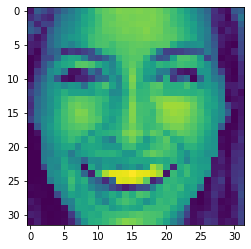

In [8]:
import matplotlib.pyplot as plt
import cv2
#img = cv2.imread('./SMILEsmileD-master/SMILEs/positives/positives7/73.jpg')
img = cv2.imread('smile1.jpeg')
img = rgb2gray(img)
img = cv2.resize(img, (32,32))
img_r = img.reshape(32,32,1)
plt.imshow(img)
class_names = ['Neutral', 'Smiling']
print_indicator(img_r, model, class_names)

Now let's try it in realtime. One way to do this is to use OpenCV for video capture, then crop and resize every frame and process it.

In [30]:
from IPython.display import clear_output
import cv2

video_capture = cv2.VideoCapture(3)
try:
    while True:
        ret, frame = video_capture.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        data = crop_and_resize(gray, 32, zoom=0.6)
        data = data.astype(np.float) / 255.
        data = data.reshape(32,32,1)
        print_indicator(data, model, class_names)
        clear_output(wait=True)
except KeyboardInterrupt:
    pass
video_capture.release()

[0.99814546 0.0018545 ]
Neutral ###-------------------------------------------------- Smiling


Alternatively, we can wait for video input with zmq, processing one frame every `display_rate` seconds. This should be running at the same time as the `ZMQVideoInput` app.

In [ ]:
from IPython.display import clear_output
from time import time
import zmq

display_rate = 1./10
addr = 'tcp://localhost:14000'

img_rows, img_cols = model.input_shape[1:]

context = zmq.Context()
subs = context.socket(zmq.SUB)
subs.setsockopt(zmq.SUBSCRIBE, '')
subs.connect(addr)
start = time()
previous = 0
try:
    while True:
        raw = subs.recv()
        duration = (time() - start) % display_rate
        if duration < previous:
            data = np.fromstring(raw, dtype=np.uint8).reshape(img_rows, img_cols)
#             show_array(data) # uncomment this to see the image
            data = data.astype(np.float) / 255.
            print_indicator(data, model, class_names)
            clear_output(wait=True)
        previous = duration
except KeyboardInterrupt:
    pass